In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import sklearn
plt.ion()

import sklearn.decomposition
import sklearn.svm
import sklearn.neighbors

In [2]:
## ici on vous donne une fonction très basique qui réalise un train/validation/split 
## il n'est PAS aléatoire
## mais au moins, on voit bien ce qu'il se passe.
def load_subSets(X, y, ratio_train=0.6, ratio_valid=0.2):
    ratio_test = 1 - ratio_train - ratio_valid #
    assert(ratio_test>0) ## on vérifie qu'il reste des exemples pour le test set
    Ntot   = X.shape[0]
    Ntrain = int(ratio_train*Ntot)
    Nvalid = int(ratio_valid*Ntot)
    Ntest  = Ntot - Ntrain - Nvalid
    X_train = X[0: Ntrain].copy()
    y_train = y[0: Ntrain].copy()
    X_valid = X[Ntrain:Ntrain+Nvalid].copy() # X[-Ntest:] est equivalent
    y_valid = y[Ntrain:Ntrain+Nvalid].copy() # X[-Ntest:] est equivalent
    X_test  = X[-Ntest:].copy()
    y_test  = y[-Ntest:].copy()
    assert(y_test.shape[0]>1) ## on vérifie qu'il reste des exemples pour le test set (on re-vérifie à cause de l'arrondi...)
    return X_train, y_train, X_valid, y_valid, X_test, y_test

## Partie 0 : choix du dataset

Pour vous guider, vous pouvez consulter les pages 19-20 du poly, qui sont un énoncé synthétique, mais qui donne la vue d'ensemble.

### Dataset 1: très bien pour commencer mais très petit, donc les expériences donneront des résultat plutôt peu intéressants dessus.


In [3]:
## data set 1 ##
K=10
import sklearn.datasets
X,y = sklearn.datasets.load_digits(n_class=K, return_X_y=True)
DimRepre = 8
ratio_train = 0.6 # on peut reduire ce nombre lorsqu'on utilise le gros data set, mnist70.npz
ratio_valid = 0.3 # on peut reduire ce nombre lorsqu'on utilise le gros data set, mnist70.npz


### Dataset 2: mieux car plus grand, donc résultats plus intéressants. Attention, les expériences peuvent mettre du temps à tourner. 

Il peut être intéressant de commencer vos recherche sur une version plus petite du dataset (en gardant que 10% des data par exemple), et quand votre code marche bien et que vous avez resséré la plage de valeurs des hyper-paramètre qui est vraisemblablement la bonne, faire une recherche plus précise sur l'ensemble du dataset.

Astuce: en particulier, n'utilisez pas un grand nombre de composantes PCA sur ce dataset (en tout cas ne faites pas PCA(grand n_comp) + featureMap_polynomiale(degré2) + SVM là dessus.

À aller chercher sur : https://gitlab.inria.fr/flandes/data-for-teaching

Dans le shell linux, faites: 
`wget https://gitlab.inria.fr/flandes/data-for-teaching/-/raw/master/mnist70.npz?inline=false`



In [4]:
# data set 2 ##
LoadObject = np.load("/home/flandes/data/mnist70.npz") ## adresse à adapter à votre cas bien sur !
DimRepre = 28
X = LoadObject['X']
y = LoadObject['y']
del LoadObject
ratio_train = 0.1  ## !! ici on ne garde que 10% pour train, pour que ça tourne vite, lorsqu'on développe le code !
ratio_valid = 0.1

### Dataset 3: même remarques que pour le 2

À aller chercher sur : https://gitlab.inria.fr/flandes/data-for-teaching



In [5]:
# ## data set 3 ##
# LoadObject = np.load("fashion-mnist-reshaped.npz")
# DimRepre = 28
# X = LoadObject['train_images']
# y = LoadObject['train_labels']
# Xtest = LoadObject['test_images']
# ytest = LoadObject['test_labels']
# X     = np.array(X    , dtype=float) ## on change le type, car c'est unsigned-int (uint) au depart
# Xtest = np.array(Xtest, dtype=float)
# del LoadObject
# ratio_train = 0.1
# ratio_valid = 0.1

## Partie 1 --  PCA: prise en main
Ici, on souhaite faire une première PCA sur les données de MNIST (où n’importe quelles données visuelles).
1. Consultez la partie 1 du TP (fichier .ipynb) [vous y êtes !]
2. Calculer la transformée en PCA des données en conservant 95% de la variance des données. Doit-on
calculer la PCA seulement sur les données d’entraînement, ou bien sur l’ensemble (train+validation) ?
Pourquoi ? (Quel est le risque, dans le mauvais cas ?)
3. Extraire le nombre de composantes effectivement retenues par la décomposition.
4. [on vous donne le code] observer le tracé du ratio de variance expliquée en fonction du nombre de composantes. 
5. À partir de la version transformée des données, calculer aussi leur version décompressée (par transformée
inverse). Afficher quelques exemples de avant/après (compression+décompression). On peut jouer avec
le taux de variance expliquée et voir l’effet sur les images. (il est recommandé d’écrire une fonction).
6. (optionnel) Calculer l’erreur de reconstruction moyenne sur toutes les images (c’est plus facile que pour une seule
image). Le faire aussi pour l’ensemble de valdiation.
7. (optionnel) Calculer l’erreur de reconstruciton pour une seule image. (inclure ceci dans la fonction de comparaison
avant/après).

Remarque: la variance expliquée est le conjugué de l'erreur quadratique moyenne de reconstruction. 
En effet, la variance (expliquée) des données correspond à la dispersion (restante) entre les valeurs des pixels (moyennée sur l’ensemble du dataset).
L’erreur de reconstruction mesure le taux d'erreur (quadratique moyenne), entre l’image de départ et l ímage reconstruite, pixel par pixel (et moyennée ensuite sur toutes les images). 
Ce sont deux notions différentes mais qui sont en correspondance: une plus grande variance expliquée correspond toujours à une plus petite erreur de reconstruction.

Text(0.5, 1.0, 'ceci est censé ressembler à un 8 avant la binarisation')

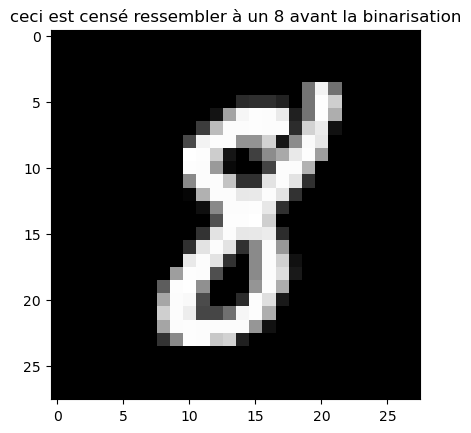

In [6]:
plt.figure()
n=41 # image numero 42
plt.imshow(X[n].reshape(DimRepre, DimRepre) , cm.gray)
plt.title("ceci est censé ressembler à un "+str(y[n])+ " avant la binarisation")


In [7]:
# on met X (les intensités de niveaux de gris) entre 0 et 1
# (pour certains datasets, c'est nécessaire, pour d'autres c'est déjà fait)
print(X.max())
X /= X.max()

0.99609375


In [8]:
## le choix est en fait à adapter selon le dataset choisi
## si il est très grand, on peut réduire le train set pour accéler le calcul
## (si on est pressé..)
ratio_train = 0.6
ratio_valid = 0.3
X_train, y_train, X_valid, y_valid, X_test, y_test = load_subSets(X, y, ratio_train=ratio_train, ratio_valid=ratio_valid)

In [9]:
X_train.shape, y_train.shape, X_valid.shape, y_valid.shape, X_test.shape, y_test.shape

((42000, 784), (42000,), (21000, 784), (21000,), (7000, 784), (7000,))

### Ici, allez voir la doc de `sklearn.decomposition.PCA`

en particulier, il y est question d'un argument d'entrée `n_components` et d'un attribut  `explained_variance_ratio_`

In [10]:
# ?sklearn.decomposition.PCA 
## c'est plus joli en ligne mais on a aussi la doc offline ! 
## pratique quand on ne se souvient plus du nom des arguments par exemple

In [11]:
### 1er essai de PCA avec "ratio de variance expliquee" fixe a 0.95

# if premiere_partie_qq_essais_a_la_main:
varianceExplained = 0.95
preProc = sklearn.decomposition.PCA( n_components=varianceExplained ) ## TODO: fixer les hyper-parametres de cette transformation
preProc.fit( X_train ) 

PCA(n_components=0.95)

In [12]:
## TODO: combien y a t il de composantes qui ont ete retenues ?
print(preProc.components_.shape[0])

154


# ATTENTION !! Utilisez `X_train` pour `fit` la `PCA`, et pas `X` tout entier !!

Même si le code tourne en faisant le fit sur X, c'est "moralement" (logiquement) pas correct: lors du pre-proc et entrainement, on n'a le *droit* de voir que les données d'entrainement !

(0.0, 1.0)

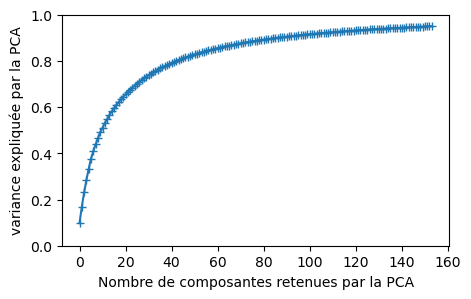

In [13]:
## tracé de la variance expliquée au total pour tous les choix de n_component réalisables 
## (pour des variances expliquees entre 0 et 0.95)
plt.figure(1, [5,3])
CumulativeExplainedVariance = np.cumsum(preProc.explained_variance_ratio_)
plt.plot(CumulativeExplainedVariance, marker='+', label="ensemble d'apprentissage (train set)")
plt.xlabel("Nombre de composantes retenues par la PCA")
plt.ylabel("variance expliquée par la PCA")
plt.ylim([0,1])
# plt.legend()

In [14]:
preProc.explained_variance_ratio_

array([0.09783692, 0.07078005, 0.0622389 , 0.05392626, 0.04871654,
       0.04355582, 0.03287275, 0.02898304, 0.0277327 , 0.02356938,
       0.02104354, 0.02020199, 0.01709671, 0.01680466, 0.01580718,
       0.01491962, 0.0131656 , 0.01261003, 0.01179484, 0.01150379,
       0.01067239, 0.01001182, 0.0095166 , 0.00908665, 0.00881784,
       0.00836146, 0.00818186, 0.00780325, 0.00738662, 0.00689171,
       0.00657141, 0.00642046, 0.0060126 , 0.0058257 , 0.0056353 ,
       0.0054015 , 0.00504286, 0.00487067, 0.00480421, 0.0047333 ,
       0.00455547, 0.00436848, 0.00415956, 0.00393383, 0.00384196,
       0.00370537, 0.00360096, 0.00349149, 0.00339121, 0.00319903,
       0.00316283, 0.00309557, 0.00292829, 0.00286531, 0.00284222,
       0.00269668, 0.0026582 , 0.00255053, 0.00251714, 0.00242438,
       0.00241219, 0.00235921, 0.00228084, 0.00221888, 0.00212381,
       0.002061  , 0.00202346, 0.00197438, 0.00192269, 0.00187953,
       0.00185544, 0.0018093 , 0.001771  , 0.00174083, 0.00164

# Explication complémentaire:

Petite explication sur l'utilisation du parametre `n_components` dans la classe PCA de sklearn :

Python est tres flexible, donc:
- si la valeur passée pour `n_components` est de type `int`, alors sklearn interprète cette valeur comme le nombre de composantes à garder dans la PCA (c'est le $D'$ de mon cours)
- si la valeur passée pour `n_components` est de type `float`  (et on espère, entre 0 et 1), sklearn l'interprète comme un ratio de variance expliquée désirée.
Dans ce 2ème cas, l'idée est la suivante: la variance des données est aussi égale à la somme des valeurs propres ($\lambda_1+\lambda_2+\ldots +\lambda_D$).
Si on garde par exemple que 2 composantes (les 2 premières), on aura une variance des données apres projection égale a $\lambda_1+\lambda_2$.
Le ratio de variance "expliquée"  (c.a.d. préservée par la PCA) sera de $$\frac{\lambda_1+\lambda_2}{\lambda_1+\lambda_2+\ldots +\lambda_D}$$
Ainsi,  si la valeur passée pour `n_components` est de type `float`, sklearn cherche des $\lambda$ jusqu'à ce que leur somme fasse 95% de la variance totale des données. Ainsi, il choisit le $D'$ à votre place... mais bon, vous avez choisi 95%, ce qui est aussi arbitraire (mais moins arbitraire que dire "gardons 10 composantes" ou bien "gardons 10% des composantes").

### Si vous êtes allés assez vite, vous pouvez faire tout ou partie de cette liste: 

(optionnel) 
- TODO: pour une image apres "compression" par PCA, calculer l'image décompressee correspondante.
- TODO: calculer ensuite l'erreur de reconstruction (erreur quadratique moyenne sur les pixels) pour une image *[éventuellement, faites ceci dans une fonction pour pouvoir rapidement comparer visuellement n'importe quel exemple d'entrainement avant et apres compression/decompression.]*
- TODO: calculer la version decompressée de tout le train-set.
- TODO : calculer l'erreur quadratique moyenne sur tout le train-set (indice: ca se fait en 1 seule ligne)

### Sinon, passez à la suite:

In [15]:
## - TODO: pour une image apres "compression" par PCA, calculer l'image décompressee correspondante.
## - TODO: calculer la version decompressée de tout le train-set:
X_train_Transformed = preProc.transform(X_train)
X_train_Transf_decompressed = preProc.inverse_transform(X_train_Transformed)
diff = X_train_Transf_decompressed - X_train # tableau de taille Nx 64
diff.shape



(42000, 784)

In [16]:
## - TODO: calculer ensuite l'erreur de reconstruction (erreur quadratique moyenne sur les pixels) pour une image *[éventuellement, faites ceci dans une fonction pour pouvoir rapidement comparer visuellement n'importe quel exemple d'entrainement avant et apres compression/decompression.]*
n=41 # image numero 42
# comparer_avant_apres_compression(n)
np.mean(diff[n]**2)

0.0022946647

In [17]:
## - TODO : calculer l'erreur quadratique moyenne sur tout le train-set (indice: ca se fait en 1 seule ligne)
totalMeanSquaredError = np.mean(diff**2)
print("MSE totale (Mean Squared Error)", totalMeanSquaredError)


MSE totale (Mean Squared Error) 0.0033438655


In [18]:
## on peut comparer avec la variance des données:
np.mean(X_train**2)

0.11249202

In [19]:
totalMeanSquaredError/np.mean(X_train**2)

0.029725358

Text(0.5, 1.0, 'ceci est censé ressembler à un 8 avant la compression')

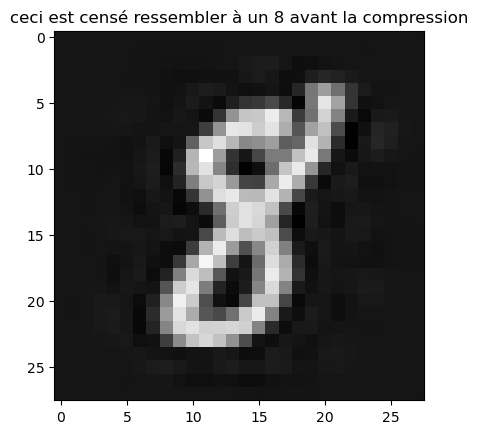

In [20]:
plt.figure()
n=41 # image numero 42
plt.imshow(X_train                    [n].reshape(DimRepre, DimRepre) , cm.gray)
plt.figure()
plt.imshow(X_train_Transf_decompressed[n].reshape(DimRepre, DimRepre) , cm.gray)
plt.title("ceci est censé ressembler à un "+str(y[n])+ " avant la compression")


# ## TODO: (pour le prof) (si on veut optmiser le temps de calcul)

- faire une seule PCA avec bcp de composantes, puis ensuite utiliser une fraction de ces composantes pour faire "comme si" on avait fait une PCA avec moins de composantes

In [21]:
D = X_train.shape[1]
erreurs = np.zeros(D)
for i, nc in enumerate(range(1,64,4)): 
    preProc = sklearn.decomposition.PCA(n_components=nc, copy=True)
    preProc.fit(X_train) # calcul de la matrice de passage par sklearn
    X_train_Transformed = preProc.transform(X_train)
    X_train_Transf_decompressed = preProc.inverse_transform(X_train_Transformed)

    diff = X_train_Transf_decompressed - X_train # tableau de taille Nx 64
    totalMeanSquaredError = np.mean(diff**2)
    erreurs[i] = totalMeanSquaredError


In [22]:
plt.plot(np.arange(D), erreurs)
plt.xlabel("n_comp")
plt.ylabel("erreur")

Text(0, 0.5, 'erreur')

Text(0, 0.5, 'erreur')

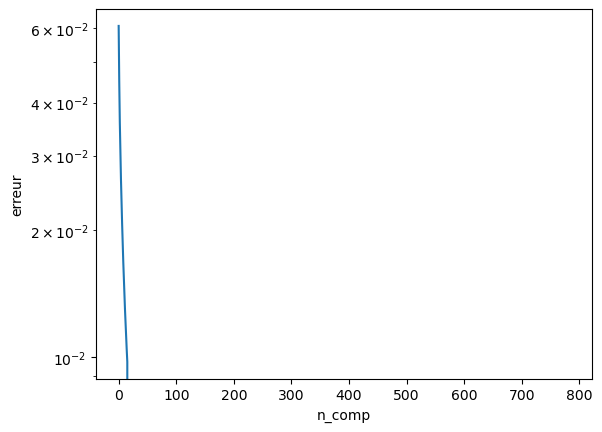

In [23]:
plt.semilogy(np.arange(D), erreurs)
plt.xlabel("n_comp")
plt.ylabel("erreur")


## Partie 2 -- Optimisation du nombre de composantes

Maintenant qu'on a compris un peu comment fonctionne la PCA, on va l'utiliser comme pré-processing:

1. Consultez la partie 2 du TP (fichier .ipynb) [vous y êtes !]
2. En faisant varier explicitement le nombre de composantes (nComp) à retenir dans la PCA, observez
comment les performances dépendent de ce nombre de composantes.
3. Sur le graphe, indiquer le point de meilleur score (le code vous est déjà donné, mais esayez de la faire par
vous même/de bien comprendre le code).

## Plus en détail:

- Commencez par utiliser la PCA comme pré processing (prenez un nombre de composantes  `n_components`  arbitraire, peu importe combien) c.a.d, transformez les données, puis, sur ces données "compressées" (après PCA), utilisez un classifieur:
    + consultez la doc de `sklearn.svm.SVC`
    + créer un SVM avec noyau (`kernel`) polynomial de degré 2
    + faites le fit de ce modèle, sur les données d'entrainement (transformées)
    + évaluez le modèle (calculez le score) sur les données d'entrainement (transformées)
    + évaluez le modèle (calculez le score) sur les données de validation (transformées aussi: essayez sans, vous verrez :P)
- une fois que ça marche pour un choix de `n_components` arbitraire, faites une boucle pour comparer plein de valeurs de `n_components`

In [24]:
X.shape

(70000, 784)

In [25]:
if X.shape[1] == 8:
    ratio_valid = 0.3
    ratio_train = 0.6
if X.shape[1] == 784:
    ratio_valid = 0.2
    ratio_train = 0.1 ## on garde tres peu pour accélerer les calculs..
X_train, y_train, X_valid, y_valid, X_test, y_test = load_subSets(X, y, ratio_train, ratio_valid)

In [26]:
X_train.shape

(7000, 784)

In [27]:
preProc = sklearn.decomposition.PCA(n_components=10) ## TODO
preProc.fit( X_train ) # on calcule l ameilleur matrice P  pour projeter les données

## TODO: transformer les donnees selon cette transformation apprise
## on applique la transformation aux données
X_train_Transformed = preProc.transform(X_train)
X_valid_Transformed = preProc.transform(X_valid)

In [28]:
## TODO: faire l'apprentissage supervisé des classes ,
## a l'aide d'un SVM polynomial de degre 2 (et avec C=1, coef0 = 1)

C = 1
degree = 2 
kernel = 'poly'
clf = sklearn.svm.SVC(C=C, kernel=kernel, degree=degree,  coef0=1)
clf.fit(X_train_Transformed, y_train)

SVC(C=1, coef0=1, degree=2, kernel='poly')

In [29]:
## TODO: calculer les scores a l'aide de clf.score()
trainscore = clf.score(X_train_Transformed, y_train) # TODO
validscore = clf.score(X_valid_Transformed, y_valid)
trainscore, validscore

(0.9324285714285714, 0.8982857142857142)

#### Maintenant, mettons tout ça dans une boucle sur `n_components`

## on essaye avec degree=3

In [35]:
linear_training_score = []
linear_valid_score = []
X_train, y_train, X_valid, y_valid, X_test, y_test = load_subSets(X, y, ratio_train, ratio_valid)
## TODO: pour differentes valeurs de n_components, realiser une PCA
## puis un apprentissssage supervise des classes
Dmax = min(X.shape[1], 64)
nComp_range = np.arange(1, Dmax, 4)
for nC in nComp_range:
    preProc = sklearn.decomposition.PCA(n_components=nC) ## TODO
    preProc.fit(X_train)
    ## TODO: transformer les donnees selon cette transformation apprise
    X_train_Transformed = preProc.transform(X_train)
    X_valid_Transformed = preProc.transform(X_valid)

    
    ## TODO: faire l'apprentissage supervisé des classes ,
    ## a l'aide d'un SVM polynomial de degre 2 (et avec C=1, coef0 = 1)
    C=1
    degree = 2
    kernel = 'poly'
    clf = sklearn.svm.SVC(C=C, kernel=kernel, degree=degree,  coef0 = 1)
    clf
    
    ## TODO: transformer les donnees selon cette transformation apprise
    clf.fit(X_train_Transformed, y_train)
    ## TODO: calculer les scores a l'aide de clf.score()
    trainscore = clf.score(X_train_Transformed, y_train) # TODO
    validscore = clf.score(X_valid_Transformed, y_valid)

    print("nombre Composants", nC , "   training score:",trainscore, ". valid score:", validscore)
    linear_training_score.append(trainscore)
    linear_valid_score.   append(validscore)


nombre Composants 1    training score: 0.30857142857142855 . valid score: 0.2997142857142857
nombre Composants 5    training score: 0.7627142857142857 . valid score: 0.7297142857142858
nombre Composants 9    training score: 0.9184285714285715 . valid score: 0.888
nombre Composants 13    training score: 0.956 . valid score: 0.9246428571428571
nombre Composants 17    training score: 0.9705714285714285 . valid score: 0.9405714285714286
nombre Composants 21    training score: 0.9772857142857143 . valid score: 0.9473571428571429
nombre Composants 25    training score: 0.9805714285714285 . valid score: 0.951
nombre Composants 29    training score: 0.9838571428571429 . valid score: 0.9532142857142857
nombre Composants 33    training score: 0.9857142857142858 . valid score: 0.9535714285714286
nombre Composants 37    training score: 0.9878571428571429 . valid score: 0.9562857142857143
nombre Composants 41    training score: 0.9887142857142858 . valid score: 0.9559285714285715
nombre Composants 

### Récupération de l'indice du meilleur choix de l'hyper-paramètre `n_components`

Ici on fait l'affichage du meilleur choix d'hyper-param (pour l'ensemble de validation évidemment).
Ici on vous montre un choix primaire, sans tenir compte de l'overfitting, etc: il peut et doit être affiné en observant les courbes (choix "à la main", à l'aide de tracés)

In [36]:
index_argmax = np.argmax(linear_valid_score)

In [37]:
nComp_range[index_argmax]

37

In [38]:
bestIndex = np.argmax(linear_valid_score) ## on trouve l'indice tel que la performance est la meilleure
bestNC = nComp_range[bestIndex] ## on récupère la valeur de l'hyper-param qui correspond
# plt.plot(bestNC, linear_valid_score[bestIndex], marker='X', color='green') ## on affiche le point

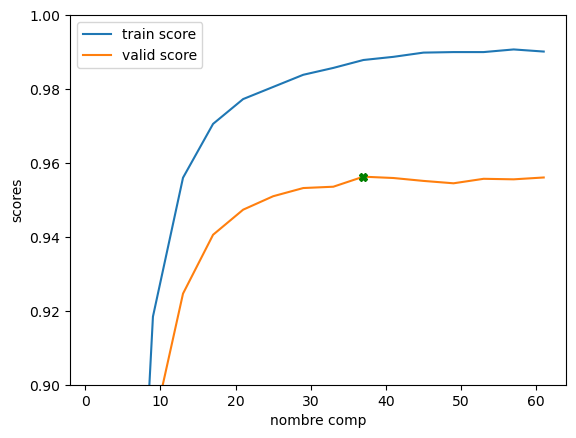

In [39]:
## plot des scores en fonction de l'hyper-param. nc
## c'est cadeau (rien à faire ici)
plt.figure()
plt.plot(nComp_range, linear_training_score, label= "train score")
plt.plot(nComp_range, linear_valid_score   , label= "valid score")
plt.xlabel("nombre comp")
plt.ylabel("scores")
plt.legend()
plt.ylim([0.9,1])
## affichage du meilleur point (ensemble de validation)
## ici on fait un choix primaire, sans tenir compte d el'overfitting, etc:
## il peut etre affiné a la main
bestIndex = np.argmax(linear_valid_score)
bestNC = nComp_range[bestIndex]
plt.plot(bestNC, linear_valid_score[bestIndex], marker='X', color='green')

In [40]:
error raised

SyntaxError: invalid syntax (783056741.py, line 1)

## avec d'autres parametres, (degré =3?), ça donne autre chose:

In [41]:
linear_training_score = []
linear_valid_score = []
X_train, y_train, X_valid, y_valid, X_test, y_test = load_subSets(X, y, ratio_train, ratio_valid)
## TODO: pour differentes valeurs de n_components, realiser une PCA
## puis un apprentissssage supervise des classes
Dmax = min(X.shape[1], 50)
nComp_range = np.arange(1, Dmax, 5)
for nC in nComp_range:
    preProc = sklearn.decomposition.PCA(n_components=nC) ## TODO
    preProc.fit(X_train)
    ## TODO: transformer les donnees selon cette transformation apprise
    X_train_Transformed = preProc.transform(X_train)
    X_valid_Transformed = preProc.transform(X_valid)

    
    ## TODO: faire l'apprentissage supervisé des classes ,
    ## a l'aide d'un SVM polynomial de degre 2 (et avec C=1, coef0 = 1)
    C=1
    degree = 2
    kernel = 'poly'
    clf = sklearn.svm.SVC(C=C, kernel=kernel, degree=degree,  coef0 = 1)
    clf
    
    ## TODO: transformer les donnees selon cette transformation apprise
    clf.fit(X_train_Transformed, y_train)
    ## TODO: calculer les scores a l'aide de clf.score()
    trainscore = clf.score(X_train_Transformed, y_train) # TODO
    validscore = clf.score(X_valid_Transformed, y_valid)

    print("nombre Composants", nC , "   training score:",trainscore, ". valid score:", validscore)
    linear_training_score.append(trainscore)
    linear_valid_score.   append(validscore)


nombre Composants 1    training score: 0.30857142857142855 . valid score: 0.2997142857142857
nombre Composants 6    training score: 0.8361428571428572 . valid score: 0.805
nombre Composants 11    training score: 0.9391428571428572 . valid score: 0.9046428571428572
nombre Composants 16    training score: 0.9675714285714285 . valid score: 0.9364285714285714
nombre Composants 21    training score: 0.977 . valid score: 0.9472142857142857
nombre Composants 26    training score: 0.9808571428571429 . valid score: 0.9508571428571428
nombre Composants 31    training score: 0.9854285714285714 . valid score: 0.9537857142857142
nombre Composants 36    training score: 0.9874285714285714 . valid score: 0.956
nombre Composants 41    training score: 0.9887142857142858 . valid score: 0.9557142857142857
nombre Composants 46    training score: 0.9898571428571429 . valid score: 0.9552857142857143


(0.8, 1.0)

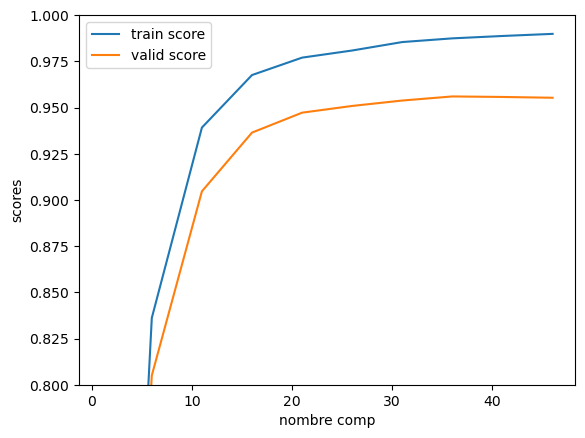

In [42]:
## plot des scores en fonction de l'hyper-param. nc
## c'est cadeau (rien à faire ici)
plt.figure()
plt.plot(nComp_range, linear_training_score, label= "train score")
plt.plot(nComp_range, linear_valid_score   , label= "valid score")
plt.xlabel("nombre comp")
plt.ylabel("scores")
plt.legend()
plt.ylim([0.8,1])

## Partie 2 bis: Cross-Validation

On a fait tout ceci pour un partage donné du train et validation set.

Pour être robuste vis-à-vis de l'aléatoire associé au tirage des données, il vaut mieux utiliser la cross-validation. Ceci est vrai en particulier pour les jeux de données avec peu d'exemple (N petit)

- faites un partage (tran+validation)/test des données, de façon déterministe (pas aléatoire), en vous inspirant de la fonction `load_subSets` donnée plus haut.
- faites vous meme une fonction de Cross-Validation:
    + faire un tableaux d'indices de 0 à N-1, mais aléatoire (mélangez les indices. Ça se dit *shuffle* en anglais) 
    + faites une méthode qui permet de piocher de façon déterminsite une tranche parmi 5 (par exemple), en choisissant la tranche
    + testez votre fonction (vérifier que quand on demande la tranche 0, puis la 1, ...  la 4, ça donne bien tout les exemples du datset, chacun étant vu une seule fois en tant que validation
- Utilisez votre méthode CrossValidation:
- pour une valeur de l'hyper-paramètre, faire 5 tirages train/validation, et mesurer les 5 scores (train+val, donc 10); enregistrer tout ces résultats
- faire à nouveau la boucle sur les valeurs de l'hyper-paramètre; enregistrer tout 

Remarque: cette fonction est implémentée dans scikit-learn: ``sklearn.model_selection.cross_validate``

In [43]:
## on fait un split train/test, en mettant rien dans le validation
if X.shape[1] == 8:
    ratio_valid = 0.0 
    ratio_train = 0.8
    ## test: le reste
if X.shape[1] == 784:
    ratio_valid = 0.0
    ratio_train = 0.1  ## on garde tres peu pour accélerer les calculs..
    ## test: le reste
X_train, y_train, X_valid, y_valid, X_test, y_test = load_subSets(X, y, ratio_train, ratio_valid)
X_valid.shape

(0, 784)

In [44]:
def CV_split(X_train_val, y_train_val, NSLICE, nc,  seed=0):
    np.random.seed(seed) ## pour la reproducibilité du découpage
    Ntrain = X_train_val.shape[0]
    index_range = np.arange(Ntrain)
    np.random.shuffle(index_range)  ## on mélange les indices
    
    def get_slice(nslice, NSLICE):
        slice_length = Ntrain//NSLICE
        tranche_validation = index_range[nslice*slice_length: (nslice+1)*slice_length]
        tranche_train = np.concatenate( ( index_range[0:nslice*slice_length] ,  index_range[(nslice+1)*slice_length:] ) )
        return tranche_train, tranche_validation
    
    trainscores = np.zeros(NSLICE)
    validscores = np.zeros(NSLICE)
    for nslice in range(NSLICE):
        tranche_train, tranche_validation = get_slice(nslice, NSLICE)
        X_train = X_train_val[tranche_train]
        y_train = y_train_val[tranche_train]
        X_valid = X_train_val[tranche_validation]
        y_valid = y_train_val[tranche_validation]
        

        preProc = sklearn.decomposition.PCA(n_components=nC) ## TODO
        preProc.fit(X_train)
        X_train_Transformed = preProc.transform(X_train)
        X_valid_Transformed = preProc.transform(X_valid)
        C=1
        degree = 2
        kernel = 'poly'
        clf = sklearn.svm.SVC(C=C, kernel=kernel, degree=degree,  coef0 = 1)
        clf.fit(X_train_Transformed, y_train)
        trainscore = clf.score(X_train_Transformed, y_train)
        validscore = clf.score(X_valid_Transformed, y_valid)
        
        trainscores[nslice] = clf.score(X_train_Transformed, y_train)
        validscores[nslice] = clf.score(X_valid_Transformed, y_valid)
    return trainscores, validscores



In [45]:
## mini test de notre fonction CV_split
nc = 10
NSLICE = 5
trainscores, validscores = CV_split(X_train, y_train, NSLICE, nc, seed=0)
trainscores, validscores

(array([0.98821429, 0.99071429, 0.98875   , 0.99071429, 0.98964286]),
 array([0.95928571, 0.96071429, 0.96928571, 0.95928571, 0.96642857]))

In [46]:
## on fait maintenant la boucle sur l'hyper-paramètre:
Dmax = min(X.shape[1], 64)
nComp_range = np.arange(1, Dmax, 4)
NSLICE = 5
training_scores_CV = np.zeros( (len(nComp_range), NSLICE) )
validati_scores_CV = np.zeros( (len(nComp_range), NSLICE) )
for i, nC in enumerate(nComp_range):
    training_scores_CV[i] , validati_scores_CV[i]  = CV_split(X_train, y_train, NSLICE, nc, seed=0)


In [47]:
training_scores_CV, validati_scores_CV

(array([[0.31017857, 0.30857143, 0.30642857, 0.30857143, 0.30428571],
        [0.76089286, 0.76428571, 0.76321429, 0.76196429, 0.76053571],
        [0.91732143, 0.91553571, 0.91482143, 0.9175    , 0.91535714],
        [0.95535714, 0.95535714, 0.95482143, 0.95892857, 0.95357143],
        [0.97035714, 0.96982143, 0.97      , 0.97035714, 0.97071429],
        [0.97696429, 0.97660714, 0.97571429, 0.97839286, 0.97714286],
        [0.98      , 0.98160714, 0.98017857, 0.98178571, 0.98125   ],
        [0.98285714, 0.98321429, 0.98339286, 0.98357143, 0.98285714],
        [0.98375   , 0.98553571, 0.98625   , 0.98607143, 0.98535714],
        [0.98553571, 0.9875    , 0.98767857, 0.9875    , 0.98660714],
        [0.9875    , 0.98839286, 0.98857143, 0.98964286, 0.98732143],
        [0.98803571, 0.98982143, 0.98928571, 0.99      , 0.98928571],
        [0.98892857, 0.99089286, 0.98982143, 0.99089286, 0.98982143],
        [0.98982143, 0.99035714, 0.99017857, 0.99160714, 0.99      ],
        [0.98982143,

In [48]:
training_scores_CV.mean(1)

array([0.30760714, 0.76217857, 0.91610714, 0.95560714, 0.97025   ,
       0.97696429, 0.98096429, 0.98317857, 0.98539286, 0.98696429,
       0.98828571, 0.98928571, 0.99007143, 0.99039286, 0.99067857,
       0.99075   ])

In [49]:
## plot des scores en fonction de l'hyper-param. nc
## c'est cadeau (rien à faire ici)
plt.figure()
plt.errorbar(nComp_range, training_scores_CV.mean(1), yerr=training_scores_CV.std(1), label= "train score")
plt.errorbar(nComp_range, validati_scores_CV.mean(1), yerr=validati_scores_CV.std(1) , label= "valid score")
plt.xlabel("nombre comp")
plt.ylabel("scores")
plt.legend()
plt.ylim([0.9,1])
linear_valid_score = validati_scores_CV.mean(1)
## affichage du meilleur point (ensemble de validation)
## ici on fait un choix primaire, sans tenir compte d el'overfitting, etc:
## il peut etre affiné a la main
bestIndex = np.argmax(linear_valid_score)
bestNC = nComp_range[bestIndex]
plt.plot(bestNC, linear_valid_score[bestIndex], marker='X', color='green')

## Autre version de la CV à la main : (merci Paul !)


In [50]:
def cv(X, y, k=5):
    indices = np.arange(X.shape[0])
    np.random.shuffle(indices)
    for i in range(k):
        valid = indices[i*X.shape[0]//k:(i+1)*X.shape[0]//k]
        train = np.concatenate((indices[:i*X.shape[0]//k], indices[(i+1)*X.shape[0]//k:]))
        yield X[train], y[train], X[valid], y[valid]

In [51]:
for X_train, y_train, X_valid, y_valid in cv(X_train,y_train):
    print(X_train.shape, X_valid.shape)

(5600, 784) (1400, 784)
(5600, 784) (1400, 784)
(5600, 784) (1400, 784)
(5600, 784) (1400, 784)
(5600, 784) (1400, 784)


In [52]:
linear_training_score_cv=[]
linear_valid_score_cv=[]
for X_train, y_train, X_valid, y_valid in cv(X_train,y_train):
    linear_training_score = []
    linear_valid_score = []
    #X_train, y_train, X_valid, y_valid, X_test, y_test = load_subSets(X)
    ## TODO: pour differentes valeurs de n_components, realiser une PCA
    ## puis un apprentissssage supervise des classes
    nComp_range = [2**i for i in range(7)]
    for nC in nComp_range:
        preProc = sklearn.decomposition.PCA(nC) 

        preProc.fit(X_train)
        ## transformer les donnees selon cette transformation apprise
        X_train_Transformed = preProc.transform(X_train)
        X_valid_Transformed = preProc.transform(X_valid)
        ## faire l'apprentissage supervisé des classes ,
        ## a l'aide d'un SVM polynomial de degre 2 (et avec C=1, coef0 = 1)
        clf = sklearn.svm.SVC(degree = 2,kernel = 'poly',C=1, coef0 = 1)
        clf.fit(X_train_Transformed, y_train)
        ## calculer les scores a l'aide de clf.score()
        trainscore = clf.score(X_train_Transformed, y_train)
        validscore =  clf.score(X_valid_Transformed,y_valid)
        print("nombre Composants", nC , "   training score:",trainscore, ". valid score:", validscore)
        linear_training_score.append(trainscore)
        linear_valid_score.   append(validscore)
    linear_training_score_cv.append(linear_training_score)
    linear_valid_score_cv.append(linear_valid_score)
linear_valid_score_cv=np.array(linear_valid_score_cv)

nombre Composants 1    training score: 0.31294642857142857 . valid score: 0.3098214285714286
nombre Composants 2    training score: 0.4816964285714286 . valid score: 0.4625
nombre Composants 4    training score: 0.6720982142857143 . valid score: 0.6553571428571429
nombre Composants 8    training score: 0.9053571428571429 . valid score: 0.8946428571428572
nombre Composants 16    training score: 0.9660714285714286 . valid score: 0.9464285714285714
nombre Composants 32    training score: 0.984375 . valid score: 0.9589285714285715
nombre Composants 64    training score: 0.9901785714285715 . valid score: 0.9625
nombre Composants 1    training score: 0.3142857142857143 . valid score: 0.3080357142857143
nombre Composants 2    training score: 0.48080357142857144 . valid score: 0.48392857142857143
nombre Composants 4    training score: 0.6629464285714286 . valid score: 0.6723214285714286
nombre Composants 8    training score: 0.9042410714285715 . valid score: 0.89375
nombre Composants 16    tra

In [53]:
## plot des scores en fonction de l'hyper-param. nc
## c'est cadeau (rien à faire ici)
plt.figure()
plt.errorbar(nComp_range, np.mean(linear_training_score_cv,axis=0)   , label= "train score",yerr=np.std(linear_training_score_cv,axis=0))
plt.errorbar(nComp_range, np.mean(linear_valid_score_cv,axis=0)   , label= "valid score",yerr=np.std(linear_valid_score_cv,axis=0))
## affichage du meilleur point (ensemble de validation)
## ici on fait un choix primaire, sans tenir compte d el'overfitting, etc:
## il peut etre affiné a la main
bestIndex = np.argmax(linear_valid_score)
bestNC = nComp_range[bestIndex]
plt.plot(bestNC, linear_valid_score[bestIndex], marker='X', color='green')
plt.xlabel("nombre comp")
plt.ylabel("scores")
plt.legend()
plt.ylim([0.5,1])

(0.5, 1.0)

## Partie 3 -- Optimisation double: nComp et C
1. Consultez la partie 3 du TP (fichier .ipynb) [vous y êtes!]
2. Vous devez chercher à optimiser à la fois `n_components` et le paramètre `C` asocié à la réglarisation du SVM. Une
grosse part du travail à déjà été fait. Prenez garde à appliquer la transformation PCA au bon moment,
de la bonne façon.
3. Le tracé de la figure (score en fonction des deux hyper-paramètres) est déjà fourni. Lisez le attentivement
(vous pouvez aussi l’améliorer, par exemple en faisant un tracé "en 3D").
4. En cherchant dans la doc de np.argmax et de np.unravel, obtenez les coordonnés du point qui réalise le
maximum de score, et affichez le.
5. (optionnel) Refaire tout cela mais en utilisant par exemple le modèle des k plus proches voisins (k-NN, cf. la doc. de la classe `sklearn.neighbors.KNeighborsClassifier`, en faisant varier le nombre de voisins au lieu de C).

In [54]:
nComp_range = np.arange(1,64,4)
hyperParam_range = [10**k  for k in range(-4,4,1)]
kernel = 'poly'
degree = 2

## si vous suivez cette convention d'enregistrement, le code (donné ci dessous) pour afficher le résultat
## fonctionnera directement. Si vous choisissez une autre convention, il faudra adapter le code..
array_training_score = np.zeros( (len(nComp_range), len(hyperParam_range)) )
array_validati_score = np.zeros( (len(nComp_range), len(hyperParam_range)) )

ratio_train = 0.4
ratio_valid = 0.4
X_train, y_train, X_valid, y_valid, X_test, y_test = load_subSets(X, y, ratio_train, ratio_valid)


In [55]:
for i, nC in enumerate(nComp_range):
    preProc = sklearn.decomposition.PCA(n_components=nC, copy=True)
    preProc.fit(X_train)
    X_train_Transformed = preProc.transform(X_train)
    X_valid_Transformed = preProc.transform(X_valid)

    for j, mu in enumerate(hyperParam_range):
        C = mu
        clf = sklearn.svm.SVC(C=C, kernel=kernel, degree = degree, coef0 = 1)

        clf.fit(X_train_Transformed, y_train)
        trainscore = clf.score(X_train_Transformed,y_train)
        validscore = clf.score(X_valid_Transformed,y_valid)
        # print("nombre Composants", nC , "   training score:",trainscore, ". valid score:", validscore)
        array_training_score[i,j] = trainscore
        array_validati_score[i,j] = validscore


#### On vous donne le code qui affiche la figure (si vous avez suivi ma façon d'enregistrer les résultats)

In [56]:
### trace de la figure ###
plt.figure()
levels=np.array([0.5,0.6,0.7,0.8,0.9,0.95,1])
# levels=np.arange(0.8,1.0,0.01) ## pour un trace plus fin
plt.contourf(array_validati_score, levels=levels)
architecture = "SVM" ## on pourrait essayer d'autres classifieurs, comme k-NN par exemple.
if architecture=='SVM':
    nameofHyperParam = 'C (SVM)'
else:
    nameofHyperParam = 'k (k-NN)'
plt.xlabel("hyper-param "+nameofHyperParam)
xtick = np.arange(len(hyperParam_range))
plt.xticks(xtick, hyperParam_range)
plt.ylabel("num. of Comp (PCA)")
ytick = np.arange(len(nComp_range))
plt.yticks(ytick, nComp_range)
plt.colorbar()
# indice_max = ## TODO chercher par vous meme (ou stackoverflow) comment trouver le argmax d'un tableau a deux entrées
# plt.scatter(indice_max[1],indice_max[0] , marker='X', color='red')
plt.savefig("hyper-param-tuning_arci="+architecture+".png")



## Partie 4: avec plus de sklearn

Il était utile de faire tout ça à la main une fois, pour bien comprendre la validation, le pré-processing, mais :
- en fait, on peut automatiser tout ça, par exemple avec `sklearn.model_selection.cross_validate`  et `Pipeline`
- lisez la doc et faites tout ça en qq lignes !
- enjoy !